# Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import datetime
import os, sys
import time
import pandas as pd

from matplotlib.pyplot import imshow, imsave
from plotly.subplots import make_subplots
import plotly.express as px
%matplotlib inline
import shutil

from google.colab import drive
import os

# gdrive_path='/content/gdrive/MyDrive/Capstone thesis Anahit/GANS - implementations/GANs/collect_into_one_architecture/'
gdrive_path='/content/gdrive/MyDrive/GANs/collect_into_one_architecture'

drive.mount('/content/gdrive', force_remount=True)
os.chdir(gdrive_path)
print(sorted(os.listdir()))


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive
['Changing_batchnorm_False.ipynb', 'Changing_batchnorm_True.ipynb', 'Changing_betas.ipynb', 'Changing_clip_values.ipynb', 'Changing_disc_iter.ipynb', 'Changing_gradient_penalty.ipynb', 'Changing_learning_rates.ipynb', 'Result-Plots.ipynb', 'Result_Plots.ipynb', '__pycache__', 'data', 'f1_precision_recall_Vanilla_GAN_learning rate.png', 'files', 'functions.py', 'functions_for_batchnorm.py', 'generated_images', 'real_images', 'result_imgs', 'results']


In [2]:
from functions import *

In [3]:
values = pd.read_csv("files/values_of_some_hyperparams.csv")
values

Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0             0             0             0             0           0   
1             1             1             1             1           1   
2             2             2             2             2           2   
3             3             3             3             3           3   

    model_name  n_noise  batch_size  n_critic  max_epochs  clip_value  \
0         WGAN      100         128         1          35        0.01   
1      WGAN_GP      100         128         2          33         NaN   
2        LSGAN      100         128         1          20         NaN   
3  Vanilla_GAN      100         128         2          20         NaN   

   best_lr  best_beta  penalty  
0    0.001        0.9      NaN  
1    0.001        0.9     10.0  
2    0.001        0.9      NaN  
3    0.001        0.9      NaN

In [4]:
# lrs = np.linspace(10**(-5), 10**(-2), num=10) # as in google brain article - they use 50, I use 10
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]

In [5]:
def run(MODEL_NAME, lrs, batch_size, n_critic, max_epoch, clip_value, n_noise, threshold, beta, random_seed = True):
  time_to_finish = []
  root1 = f"results/models/learning_rate/{MODEL_NAME}/"
  root2 = f"results/imgs/learning_rate/{MODEL_NAME}/"
  for i in lrs:
    start_time = time.time()
    path_model = root1 + "lr_" + str(i)
    path_img = root2 + "lr_" + str(i)

    if os.path.exists(path_img):
      shutil.rmtree(path_img)
      print(f"Removed {path_img}")
      os.mkdir(path_img)
    else:
      os.mkdir(path_img)
    
    if os.path.exists(path_model):
      shutil.rmtree(path_model)
      print(f"Removed {path_model}")
      os.mkdir(path_model)

    else:
      os.mkdir(path_model)
    print(path_model)
    print(path_img)
    print("*"*30)
    print("\n Training LR = ", i, "!")
    if MODEL_NAME == "Vanilla_GAN":
      train_Vanilla_GAN(model_name = MODEL_NAME, path_model = f"{path_model}", path_img = f"{path_img}",
                learning_rate = i, batch_size = batch_size, n_critic = n_critic,  max_epoch = max_epoch, n_noise = n_noise, random_seed = random_seed, 
                threshold = threshold, beta=beta)
    elif MODEL_NAME == "LSGAN":
      train_LSGAN(model_name = MODEL_NAME, path_model = f"{path_model}", path_img = f"{path_img}",
              learning_rate = i, batch_size = batch_size, n_critic = n_critic,  max_epoch = max_epoch, n_noise = n_noise, random_seed = random_seed,
              threshold = threshold, beta=beta)
    elif  MODEL_NAME == "WGAN":
      train_WGAN(model_name = MODEL_NAME, path_model = f"{path_model}", path_img = f"{path_img}",
              learning_rate = i, batch_size = batch_size, n_critic = n_critic,  max_epoch = max_epoch, clip_value = clip_value, n_noise = n_noise,
              random_seed = random_seed, threshold = threshold, beta=beta)
    elif MODEL_NAME == "WGAN_GP":
      train_WGAN_GP(model_name = MODEL_NAME, path_model = f"{path_model}", path_img = f"{path_img}",
              learning_rate = i, batch_size = batch_size, n_critic = n_critic,  max_epoch = max_epoch, n_noise = n_noise, random_seed = random_seed,
              threshold = threshold, beta=beta)
    end_time = time.time()
    
    print("*"*30)
    time_to_finish.append(end_time - start_time)
  print("RUN TIME: ", time_to_finish)

  result_time = pd.DataFrame()
  result_time["time"] = time_to_finish
  result_time["lr"] = lrs
  result_time["lr"] = result_time["lr"].astype('str')
  result_time.to_csv(f"results/models/learning_rate/{MODEL_NAME}_runing_times.csv")

# GANs Comparative Analysis

# Learning Rate Analysis

## Vanilla GAN LR Change 


In [6]:
MODEL_NAME = values[values.model_name=="Vanilla_GAN"].model_name.values[0]
n_noise = values[values.model_name=="Vanilla_GAN"].n_noise.values[0]
batch_size = int(values[values.model_name=="Vanilla_GAN"].batch_size.values[0])
n_critic = values[values.model_name=="Vanilla_GAN"].n_critic.values[0]
max_epoch = values[values.model_name=="Vanilla_GAN"].max_epochs.values[0]
clip_value = values[values.model_name=="Vanilla_GAN"].clip_value.values[0]
beta = values[values.model_name=="Vanilla_GAN"].best_beta.values[0]


In [7]:
# run(
#   MODEL_NAME = MODEL_NAME,
#   lrs = lrs,
#   batch_size = batch_size,
#   n_critic = n_critic,
#   max_epoch = max_epoch, 
#   clip_value = clip_value,
#   n_noise = n_noise,
#   threshold = 0.5,
#   beta = beta)

In [8]:
print("Vanilla GAN lr = 0.1")
plot_f1_precison_recall("results/models/learning_rate/Vanilla_GAN/lr_0.1/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/Vanilla_GAN/lr_0.1/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")

print("Vanilla GAN lr = 0.01")
plot_f1_precison_recall("results/models/learning_rate/Vanilla_GAN/lr_0.01/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/Vanilla_GAN/lr_0.01/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")

print("Vanilla GAN lr = 0.001")
plot_f1_precison_recall("results/models/learning_rate/Vanilla_GAN/lr_0.001/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/Vanilla_GAN/lr_0.001/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")

print("Vanilla GAN lr = 0.0001")
plot_f1_precison_recall("results/models/learning_rate/Vanilla_GAN/lr_0.0001/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/Vanilla_GAN/lr_0.0001/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")

print("Vanilla GAN lr = 0.00001")
plot_f1_precison_recall("results/models/learning_rate/Vanilla_GAN/lr_1e-05/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/Vanilla_GAN/lr_1e-05/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")

Vanilla GAN lr = 0.1


Vanilla GAN lr = 0.01


Vanilla GAN lr = 0.001


Vanilla GAN lr = 0.0001


Vanilla GAN lr = 0.00001


Vanilla_GAN, Learning Rate = 0.1


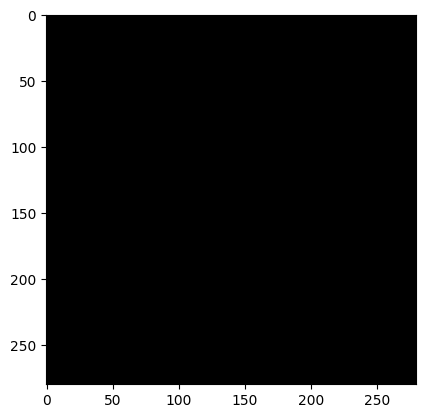

Vanilla_GAN, Learning Rate = 0.01


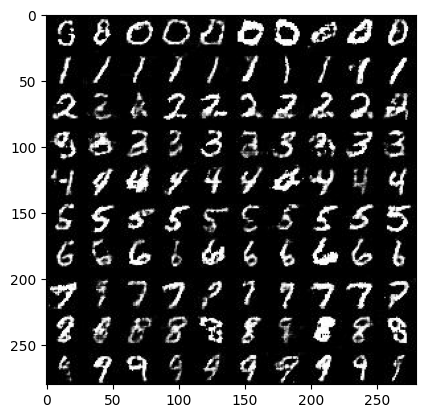

Vanilla_GAN, Learning Rate = 0.001


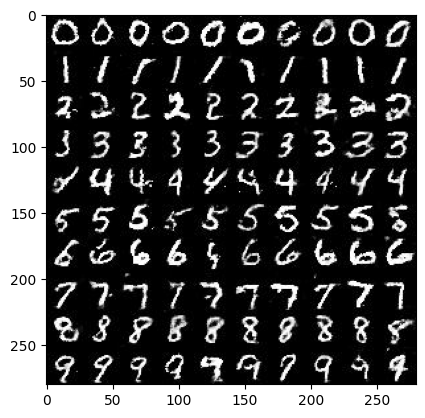

Vanilla_GAN, Learning Rate = 0.0001


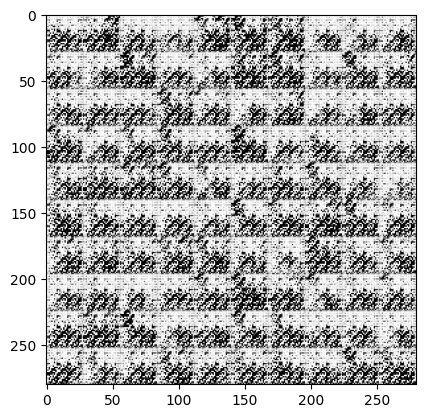

Vanilla_GAN, Learning Rate = 1e-05


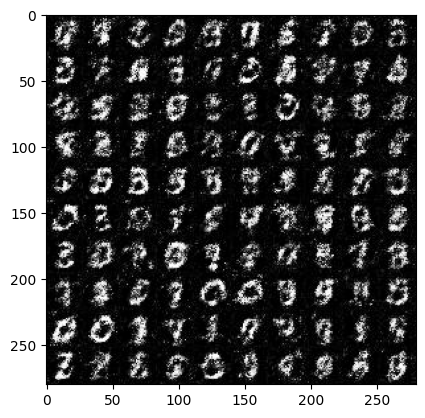

In [9]:
MODEL_NAME = "Vanilla_GAN"
for lr in lrs:
  print(f"{MODEL_NAME}, Learning Rate = {lr}")
  path = f"results/imgs/learning_rate/{MODEL_NAME}/lr_{lr}/{MODEL_NAME}_last.jpg"
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.show()

# LSGAN

In [ ]:
MODEL_NAME = values[values.model_name=="LSGAN"].model_name.values[0]
n_noise = values[values.model_name=="LSGAN"].n_noise.values[0]
batch_size = int(values[values.model_name=="LSGAN"].batch_size.values[0])
n_critic = values[values.model_name=="LSGAN"].n_critic.values[0]
max_epoch = values[values.model_name=="LSGAN"].max_epochs.values[0]
clip_value = values[values.model_name=="LSGAN"].clip_value.values[0]
beta = values[values.model_name=="LSGAN"].best_beta.values[0]


In [ ]:
# run(
#   MODEL_NAME = MODEL_NAME,
#   lrs = lrs,
#   batch_size = batch_size,
#   n_critic = 1,
#   max_epoch = max_epoch, 
#   clip_value = clip_value,
#   n_noise = n_noise,
#   threshold = 0.5,
#   beta = beta)

In [ ]:
print("LSGAN lr = 0.1")
plot_f1_precison_recall("results/models/learning_rate/LSGAN/lr_0.1/LSGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/LSGAN/lr_0.1/LSGAN_G_D_loss_scores_per_epoch.csv")

print("LSGAN lr = 0.01")
plot_f1_precison_recall("results/models/learning_rate/LSGAN/lr_0.01/LSGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/LSGAN/lr_0.01/LSGAN_G_D_loss_scores_per_epoch.csv")

print("LSGAN lr = 0.001")
plot_f1_precison_recall("results/models/learning_rate/LSGAN/lr_0.001/LSGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/LSGAN/lr_0.001/LSGAN_G_D_loss_scores_per_epoch.csv")

print("LSGAN lr = 0.0001")
plot_f1_precison_recall("results/models/learning_rate/LSGAN/lr_0.0001/LSGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/LSGAN/lr_0.0001/LSGAN_G_D_loss_scores_per_epoch.csv")

print("LSGAN lr = 0.00001")
plot_f1_precison_recall("results/models/learning_rate/LSGAN/lr_1e-05/LSGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/LSGAN/lr_1e-05/LSGAN_G_D_loss_scores_per_epoch.csv")

LSGAN lr = 0.1


LSGAN lr = 0.01


LSGAN lr = 0.001


LSGAN lr = 0.0001


LSGAN lr = 0.00001


LSGAN, Learning Rate = 0.1


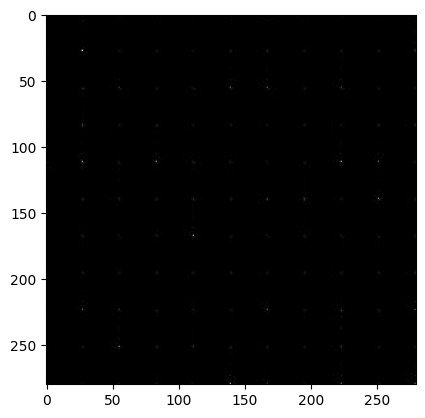

LSGAN, Learning Rate = 0.01


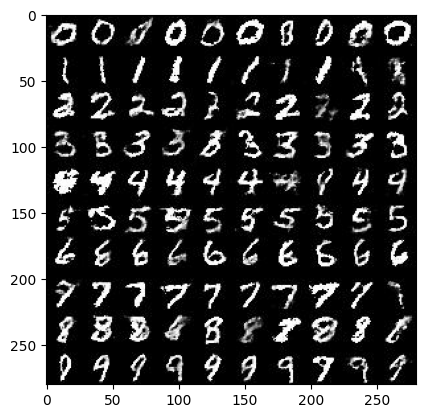

LSGAN, Learning Rate = 0.001


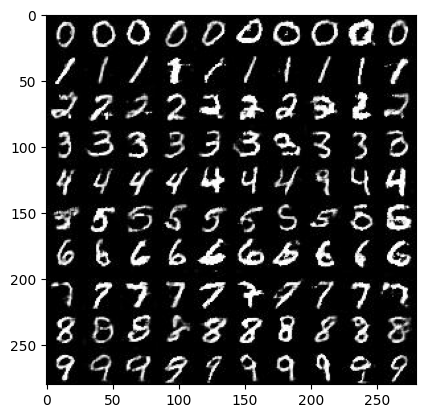

LSGAN, Learning Rate = 0.0001


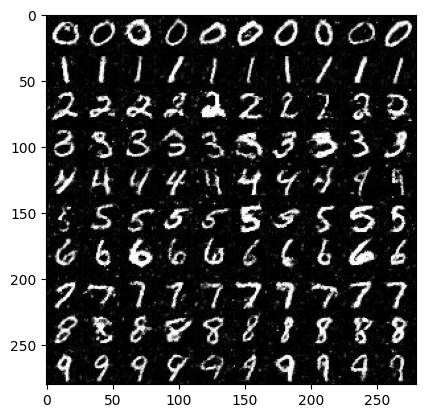

LSGAN, Learning Rate = 1e-05


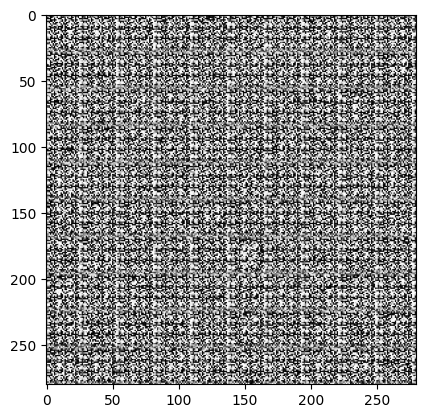

In [ ]:
MODEL_NAME = "LSGAN"
for lr in lrs:
  print(f"{MODEL_NAME}, Learning Rate = {lr}")
  path = f"results/imgs/learning_rate/{MODEL_NAME}/lr_{lr}/{MODEL_NAME}_last.jpg"
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.show()

# WGAN GP

In [ ]:
MODEL_NAME = values[values.model_name=="WGAN_GP"].model_name.values[0]
n_noise = values[values.model_name=="WGAN_GP"].n_noise.values[0]
batch_size = int(values[values.model_name=="WGAN_GP"].batch_size.values[0])
n_critic = values[values.model_name=="WGAN_GP"].n_critic.values[0]
max_epoch = values[values.model_name=="WGAN_GP"].max_epochs.values[0]
clip_value = values[values.model_name=="WGAN_GP"].clip_value.values[0]
beta = values[values.model_name=="WGAN_GP"].best_beta.values[0]


In [ ]:
# run(
#   MODEL_NAME = MODEL_NAME,
#   lrs = lrs,
#   batch_size = batch_size,
#   n_critic = 2,#n_critic
#   max_epoch = 33, #max_epoch
#   clip_value = clip_value,
#   n_noise = n_noise,
#   threshold = 0.5,
#   beta = beta)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("WGAN_GP lr = 0.1")
plot_f1_precison_recall("results/models/learning_rate/WGAN_GP/lr_0.1/WGAN_GP_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN_GP/lr_0.1/WGAN_GP_G_D_loss_scores_per_epoch.csv")

print("WGAN_GP lr = 0.01")
plot_f1_precison_recall("results/models/learning_rate/WGAN_GP/lr_0.01/WGAN_GP_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN_GP/lr_0.01/WGAN_GP_G_D_loss_scores_per_epoch.csv")

print("WGAN_GP lr = 0.001")
plot_f1_precison_recall("results/models/learning_rate/WGAN_GP/lr_0.001/WGAN_GP_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN_GP/lr_0.001/WGAN_GP_G_D_loss_scores_per_epoch.csv")

print("WGAN_GP lr = 0.0001")
plot_f1_precison_recall("results/models/learning_rate/WGAN_GP/lr_0.0001/WGAN_GP_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN_GP/lr_0.0001/WGAN_GP_G_D_loss_scores_per_epoch.csv")

print("WGAN_GP lr = 0.00001")
plot_f1_precison_recall("results/models/learning_rate/WGAN_GP/lr_1e-05/WGAN_GP_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN_GP/lr_1e-05/WGAN_GP_G_D_loss_scores_per_epoch.csv")

WGAN_GP lr = 0.1


WGAN_GP lr = 0.01


WGAN_GP lr = 0.001


WGAN_GP lr = 0.0001


WGAN_GP lr = 0.00001


WGAN_GP, Learning Rate = 0.1


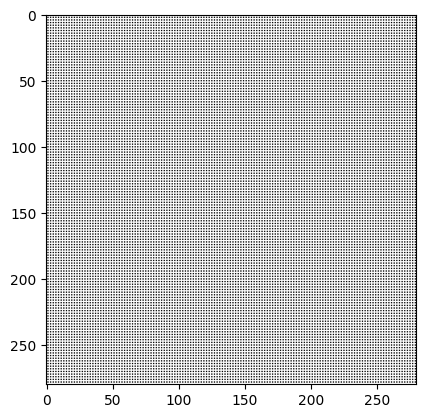

WGAN_GP, Learning Rate = 0.01


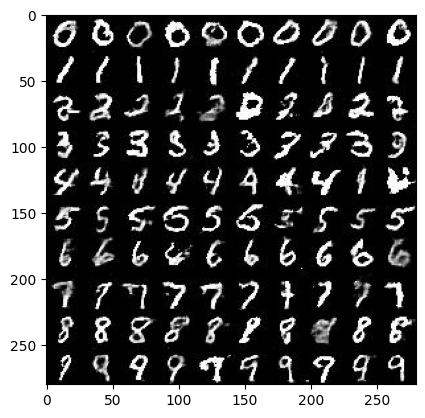

WGAN_GP, Learning Rate = 0.001


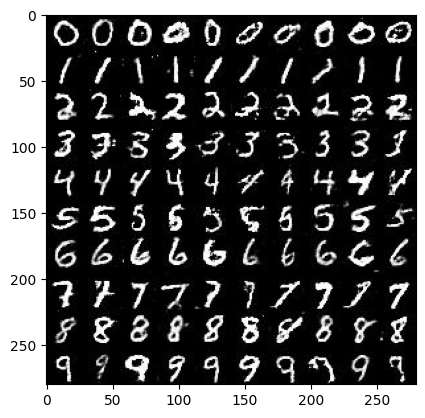

WGAN_GP, Learning Rate = 0.0001


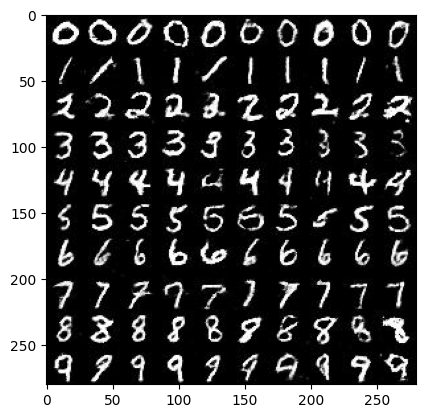

WGAN_GP, Learning Rate = 1e-05


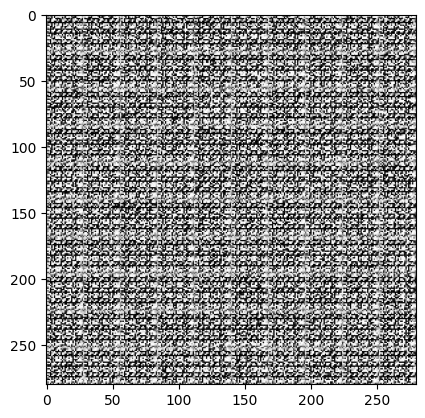

In [ ]:
MODEL_NAME = "WGAN_GP"
for lr in lrs:
  print(f"{MODEL_NAME}, Learning Rate = {lr}")
  path = f"results/imgs/learning_rate/{MODEL_NAME}/lr_{lr}/{MODEL_NAME}_last.jpg"
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.show()

# WGAN

In [ ]:
MODEL_NAME = values[values.model_name=="WGAN"].model_name.values[0]
n_noise = values[values.model_name=="WGAN"].n_noise.values[0]
batch_size = int(values[values.model_name=="WGAN"].batch_size.values[0])
n_critic = values[values.model_name=="WGAN"].n_critic.values[0]
max_epoch = values[values.model_name=="WGAN"].max_epochs.values[0]
clip_value = values[values.model_name=="WGAN"].clip_value.values[0]
beta = values[values.model_name=="WGAN"].best_beta.values[0]


In [ ]:

# run(
#   MODEL_NAME = MODEL_NAME,
#   lrs = lrs,
#   batch_size = batch_size,
#   n_critic = n_critic,
#   max_epoch = max_epoch, 
#   clip_value = clip_value,
#   n_noise = n_noise,
#   threshold = 0.5,
#   beta = beta)

In [ ]:
print("WGAN lr = 0.1")
plot_f1_precison_recall("results/models/learning_rate/WGAN/lr_0.1/WGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN/lr_0.1/WGAN_G_D_loss_scores_per_epoch.csv")

print("WGAN lr = 0.01")
plot_f1_precison_recall("results/models/learning_rate/WGAN/lr_0.01/WGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN/lr_0.01/WGAN_G_D_loss_scores_per_epoch.csv")

print("WGAN lr = 0.001")
plot_f1_precison_recall("results/models/learning_rate/WGAN/lr_0.001/WGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN/lr_0.001/WGAN_G_D_loss_scores_per_epoch.csv")

print("WGAN lr = 0.0001")
plot_f1_precison_recall("results/models/learning_rate/WGAN/lr_0.0001/WGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN/lr_0.0001/WGAN_G_D_loss_scores_per_epoch.csv")

print("WGAN lr = 0.00001")
plot_f1_precison_recall("results/models/learning_rate/WGAN/lr_1e-05/WGAN_G_D_loss_scores_per_epoch.csv")
plot_loss("results/models/learning_rate/WGAN/lr_1e-05/WGAN_G_D_loss_scores_per_epoch.csv")

WGAN lr = 0.1


WGAN lr = 0.01


WGAN lr = 0.001


WGAN lr = 0.0001


WGAN lr = 0.00001


WGAN, Learning Rate = 0.1


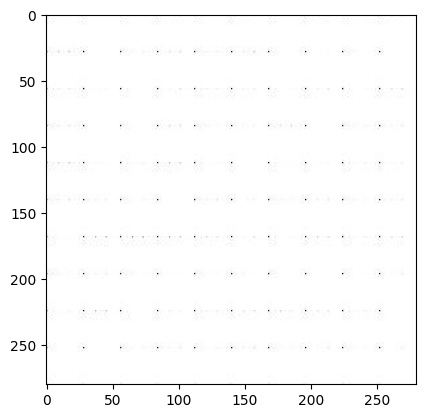

WGAN, Learning Rate = 0.01


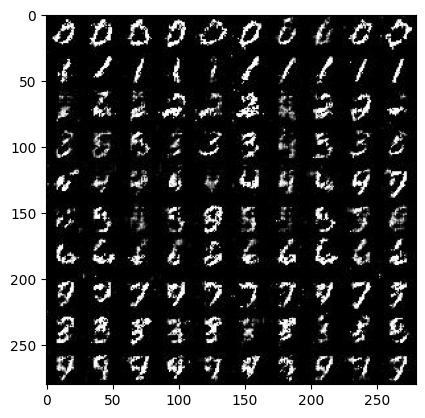

WGAN, Learning Rate = 0.001


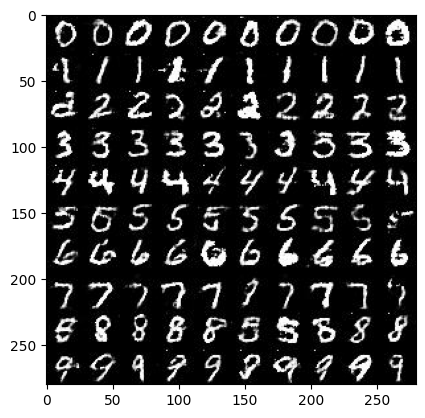

WGAN, Learning Rate = 0.0001


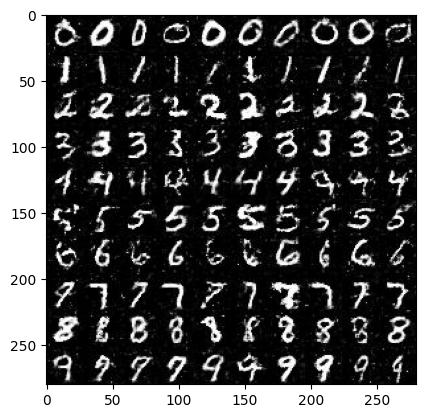

WGAN, Learning Rate = 1e-05


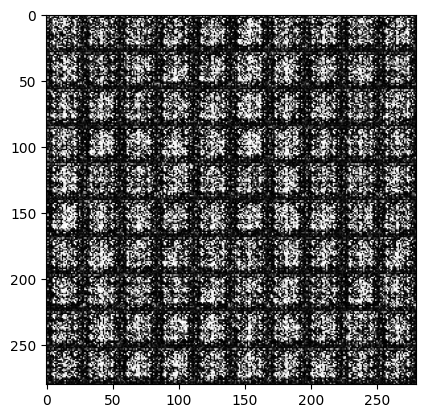

In [ ]:
MODEL_NAME = "WGAN"
for lr in lrs:
  print(f"{MODEL_NAME}, Learning Rate = {lr}")
  path = f"results/imgs/learning_rate/{MODEL_NAME}/lr_{lr}/{MODEL_NAME}_last.jpg"
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.show()

# FID SCORE

## Vanilla GAN

In [ ]:
# def Generate_images_for_FID(digit, model_path, save_path, num_images=100):
#   # Set up the device
#   device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#   # Set up the generator and load the saved weights
#   checkpoint = torch.load(f"{model_path}/model.tar")

#   generator = Generator().to(device)
#   # generator.load_state_dict(torch.load("generator_weights.pth", map_location=device))
#   generator.load_state_dict(checkpoint['G_state_dict'])

#   # Set up the noise vector and condition vector
#   noise = Variable(torch.randn(num_images, 100)).to(device)
#   condition = Variable(torch.zeros(num_images, 10)).to(device)
#   condition[:, int(digit)] = 1  # set the condition vector to generate only 0 digits

#   directory_name = f"{save_path}/{digit}"
  
#   if os.path.exists(directory_name):
#       # If it exists, remove it recursively
#       shutil.rmtree(directory_name)

#   # Create a new directory
#   os.mkdir(directory_name)
#   # Generate and save the images
#   for i in range(num_images):
#       with torch.no_grad():
#           fake_image = generator(noise[i].unsqueeze(0), condition[i].unsqueeze(0)).detach().cpu()
#       image_path = f"{save_path}/{digit}/generated_image_{i}.png"
#       vutils.save_image(fake_image, image_path, normalize=True)
#       # # Open the saved image and display it
#       # img = Image.open(image_path)
#       # img.show()

In [ ]:
MODEL_NAME = "Vanilla_GAN"
for lr in lrs:
  path = f"generated_images/learning_rate/{MODEL_NAME}/"
  add = "lr_" + str(lr)
  path = path + add
  model_path = f"results/models/learning_rate/{MODEL_NAME}/" + add
  # print(model_path)
  if os.path.exists(path):
      shutil.rmtree(path)
      # print(f"removed {path}")
  os.mkdir(path)
  # print(f"created {path}")
  for digit in range(0,10):
    digit = str(digit)
    Generate_images_for_FID(digit = digit, model_path = model_path, num_images = 100, save_path = path)

In [ ]:
fid_scores = []
for lr in lrs:
  path = f"generated_images/learning_rate/{MODEL_NAME}/"
  add = "lr_" + str(lr)
  path = path + add
  print(path)
  real_images_path = "real_images"
  generated_images_path = path
  batch_size = 20
  fid = calculate_fid_score(real_images_path, generated_images_path, batch_size)
  print(f"FID score: {fid}")
  fid_scores.append(fid)

generated_images/Vanilla_GAN/lr_0.1


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 235.88009732197696
generated_images/Vanilla_GAN/lr_0.01
FID score: 107.19097054588349
generated_images/Vanilla_GAN/lr_0.001
FID score: 87.73311094205502
generated_images/Vanilla_GAN/lr_0.0001
FID score: 361.19194982616636
generated_images/Vanilla_GAN/lr_1e-05
FID score: 183.97809334803998


In [ ]:
fid_df = pd.DataFrame()
fid_df["fid_score"] = fid_scores
fid_df["model_name"] = MODEL_NAME
fid_df["lr"] = lrs
fid_df.to_csv(f"results/models/learning_rate/{MODEL_NAME}_FID_scores_vs_lr.csv")

## LSGAN

In [ ]:
MODEL_NAME = "LSGAN"
for lr in lrs:
  path = f"generated_images/learning_rate/{MODEL_NAME}/"
  add = "lr_" + str(lr)
  path = path + add
  model_path = f"results/models/learning_rate/{MODEL_NAME}/" + add
  # print(model_path)
  if os.path.exists(path):
      shutil.rmtree(path)
      # print(f"removed {path}")
  os.mkdir(path)
  # print(f"created {path}")

  for digit in range(0,10):
    digit = str(digit)
    Generate_images_for_FID(digit = digit, model_path = model_path, num_images = 100, save_path = path)

In [ ]:
fid_scores = []
for lr in lrs:
  path = f"generated_images/learning_rate/{MODEL_NAME}/"
  add = "lr_" + str(lr)
  path = path + add
  print(path)
  real_images_path = "real_images"
  generated_images_path = path
  batch_size = 20
  fid = calculate_fid_score(real_images_path, generated_images_path, batch_size)
  print(f"FID score: {fid}")
  fid_scores.append(fid)
  fid_df

generated_images/LSGAN/lr_0.1


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 252.3596612228526
generated_images/LSGAN/lr_0.01
FID score: 99.11822119207932
generated_images/LSGAN/lr_0.001
FID score: 82.27821490106152
generated_images/LSGAN/lr_0.0001
FID score: 93.48265602389392
generated_images/LSGAN/lr_1e-05
FID score: 411.1949579875052


In [ ]:
fid_df = pd.DataFrame()
fid_df["fid_score"] = fid_scores
fid_df["model_name"] = MODEL_NAME
fid_df["lr"] = lrs
fid_df.to_csv(f"results/models/learning_rate/{MODEL_NAME}_FID_scores_vs_lr.csv")

## WGAN

In [ ]:
MODEL_NAME = "WGAN"
for lr in lrs:
  path = f"generated_images/learning_rate/{MODEL_NAME}/"
  add = "lr_" + str(lr)
  path = path + add
  model_path = f"results/models/learning_rate/{MODEL_NAME}/" + add
  # print(model_path)
  if os.path.exists(path):
      shutil.rmtree(path)
      # print(f"removed {path}")
  os.mkdir(path)
  # print(f"created {path}")

  for digit in range(0,10):
    digit = str(digit)
    Generate_images_for_FID(digit = digit, model_path = model_path, num_images = 100, save_path = path)

In [ ]:
fid_scores = []
for lr in lrs:
  path = f"generated_images/learning_rate/{MODEL_NAME}/"
  add = "lr_" + str(lr)
  path = path + add
  print(path)
  real_images_path = "real_images"
  generated_images_path = path
  batch_size = 20
  fid = calculate_fid_score(real_images_path, generated_images_path, batch_size)
  print(f"FID score: {fid}")
  fid_scores.append(fid)
  fid_scores

generated_images/WGAN/lr_0.1


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 231.30101943139846
generated_images/WGAN/lr_0.01
FID score: 117.97245488372735
generated_images/WGAN/lr_0.001
FID score: 91.14809589933628
generated_images/WGAN/lr_0.0001
FID score: 109.8525489905033
generated_images/WGAN/lr_1e-05
FID score: 389.0798140069311


In [ ]:
fid_df = pd.DataFrame()
fid_df["fid_score"] = fid_scores
fid_df["model_name"] = MODEL_NAME
fid_df["lr"] = lrs
fid_df.to_csv(f"results/models/learning_rate/{MODEL_NAME}_FID_scores_vs_lr.csv")

## WGAN GP

In [ ]:
MODEL_NAME = "WGAN_GP"
for lr in lrs:
  path = f"generated_images/{MODEL_NAME}/"
  add = "lr_" + str(lr)
  path = path + add
  model_path = f"results/models/learning_rate/{MODEL_NAME}/" + add
  # print(model_path)
  if os.path.exists(path):
      shutil.rmtree(path)
      # print(f"removed {path}")
  os.mkdir(path)
  # print(f"created {path}")

  for digit in range(0,10):
    digit = str(digit)
    Generate_images_for_FID(digit = digit, model_path = model_path, num_images = 100, save_path = path)

In [ ]:
fid_scores = []
for lr in lrs:
  path = f"generated_images/{MODEL_NAME}/"
  add = "lr_" + str(lr)
  path = path + add
  print(path)
  real_images_path = "real_images"
  generated_images_path = path
  batch_size = 20
  fid = calculate_fid_score(real_images_path, generated_images_path, batch_size)
  print(f"FID score: {fid}")
  fid_scores.append(fid)
  fid_scores

generated_images/WGAN_GP/lr_0.1


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 386.74145967349546
generated_images/WGAN_GP/lr_0.01
FID score: 83.6384505544477
generated_images/WGAN_GP/lr_0.001
FID score: 75.86272056227082
generated_images/WGAN_GP/lr_0.0001
FID score: 75.46065965291399
generated_images/WGAN_GP/lr_1e-05
FID score: 370.82483725741247


In [ ]:
fid_df = pd.DataFrame()
fid_df["fid_score"] = fid_scores
fid_df["model_name"] = MODEL_NAME
fid_df["lr"] = lrs
fid_df.to_csv(f"results/models/learning_rate/{MODEL_NAME}_FID_scores_vs_lr.csv")

# Learning Rates VS Loss

### Vanilla GAN

In [ ]:
MODEL_NAME = "Vanilla_GAN"
trained_lrs = os.listdir(f"results/models/learning_rate/{MODEL_NAME}/")
root = f"results/models/learning_rate/{MODEL_NAME}/"
G_loss_list = []
D_loss_list = []


for trained_lr, lr in zip(trained_lrs, lrs):
  print(lr)
  path = root + trained_lr + "/"

  G_loss, D_loss = load_model(path, lr, n_noise)
  G_loss_list.append(G_loss.item())
  D_loss_list.append(D_loss.item())

  print("D = ",D_loss.item(), "G = ",G_loss.item())


0.1
D =  1.626523494720459 G =  0.3132617473602295
0.01
D =  1.006408929824829 G =  0.6931471824645996
0.001
D =  1.3862947225570679 G =  0.6929550170898438
0.0001
D =  1.1519973278045654 G =  0.6679368019104004
1e-05
D =  1.1125916242599487 G =  0.6492342352867126


In [ ]:
result_loss = pd.DataFrame()
result_loss["D_loss"] = D_loss_list
result_loss["G_loss"] = G_loss_list
result_loss["lr"] = lrs
result_loss["lr"] = result_loss["lr"].astype('str')
result_loss['size'] = 5
result_loss.to_csv(f"results/models/learning_rate/{MODEL_NAME}_loss_values.csv")
result_loss

D_loss    G_loss      lr  size
0  1.626523  0.313262     0.1     5
1  1.006409  0.693147    0.01     5
2  1.386295  0.692955   0.001     5
3  1.151997  0.667937  0.0001     5
4  1.112592  0.649234   1e-05     5

In [ ]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(px.scatter(result_loss, x="lr", y="D_loss",  size="size").data[0], row=1, col=1)
fig.add_trace(px.scatter(result_loss, x="lr", y="G_loss",  size="size").data[0], row=1, col=2)
fig.update_layout(title="Loss vs Learning Rates", 
                  xaxis=dict(title="Learning Rates"),
                  yaxis=dict(title="Loss"))

fig.show()

In [ ]:
result_time = pd.read_csv(f"results/models/learning_rate/{MODEL_NAME}_runing_times.csv")
result_time["size"] = 5

In [ ]:
fig = px.scatter(result_time, x="lr", y="time", color="lr", size="size", title = "run time vs LR")
fig.show()

### LSGAN

In [ ]:
MODEL_NAME = "LSGAN"
trained_lrs = os.listdir(f"results/models/learning_rate/{MODEL_NAME}/")
root = f"results/models/learning_rate/{MODEL_NAME}/"
G_loss_list = []
D_loss_list = []


for trained_lr, lr in zip(trained_lrs, lrs):
  print(lr)
  path = root + trained_lr + "/"

  G_loss, D_loss = load_model(path, lr, n_noise)
  G_loss_list.append(G_loss.item())
  D_loss_list.append(D_loss.item())

  print("D = ",D_loss.item(), "G = ",G_loss.item())


0.1
D =  0.5 G =  0.0
0.01
D =  0.25000467896461487 G =  0.252347469329834
0.001
D =  0.1473889946937561 G =  0.28417739272117615
0.0001
D =  0.19360722601413727 G =  0.5597941875457764
1e-05
D =  0.01633414998650551 G =  0.7584747672080994


In [ ]:
result_loss = pd.DataFrame()
result_loss["D_loss"] = D_loss_list
result_loss["G_loss"] = G_loss_list
result_loss["lr"] = lrs
result_loss["lr"] = result_loss["lr"].astype('str')
result_loss['size'] = 5
result_loss.to_csv(f"results/models/learning_rate/{MODEL_NAME}_loss_values.csv")
result_loss

D_loss    G_loss      lr  size
0  0.500000  0.000000     0.1     5
1  0.250005  0.252347    0.01     5
2  0.147389  0.284177   0.001     5
3  0.193607  0.559794  0.0001     5
4  0.016334  0.758475   1e-05     5

In [ ]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(px.scatter(result_loss, x="lr", y="D_loss",  size="size").data[0], row=1, col=1)
fig.add_trace(px.scatter(result_loss, x="lr", y="G_loss",  size="size").data[0], row=1, col=2)
fig.update_layout(title="Loss vs Learning Rates", 
                  xaxis=dict(title="Learning Rates"),
                  yaxis=dict(title="Loss"))

fig.show()

In [ ]:
result_time = pd.read_csv(f"results/models/learning_rate/{MODEL_NAME}_runing_times.csv")
result_time["size"] = 5

In [ ]:
fig = px.scatter(result_time, x="lr", y="time", color="lr", size="size", title = "run time vs LR")
fig.show()

### WGAN LR Change 


In [ ]:
MODEL_NAME = "WGAN"
trained_lrs = os.listdir(f"results/models/learning_rate/{MODEL_NAME}/")
root = f"results/models/learning_rate/{MODEL_NAME}/"
G_loss_list = []
D_loss_list = []


for trained_lr, lr in zip(trained_lrs, lrs):
  print(lr)
  path = root + trained_lr + "/"

  G_loss, D_loss = load_model(path, lr, n_noise)
  G_loss_list.append(G_loss.item())
  D_loss_list.append(D_loss.item())

  print("D = ",D_loss.item(), "G = ",G_loss.item())


0.1
D =  0.0 G =  -1.0
0.01
D =  0.0 G =  -1.0
0.001
D =  -0.980334997177124 G =  -0.0005088424077257514
0.0001
D =  -0.2850910425186157 G =  -0.33932727575302124
1e-05
D =  -0.9383123517036438 G =  -0.02530805580317974


In [ ]:
result_loss = pd.DataFrame()
result_loss["D_loss"] = D_loss_list
result_loss["G_loss"] = G_loss_list
result_loss["lr"] = lrs
result_loss["lr"] = result_loss["lr"].astype('str')
result_loss['size'] = 5
result_loss.to_csv(f"results/models/learning_rate/{MODEL_NAME}_loss_values.csv")
result_loss

D_loss    G_loss      lr  size
0  0.000000 -1.000000     0.1     5
1  0.000000 -1.000000    0.01     5
2 -0.980335 -0.000509   0.001     5
3 -0.285091 -0.339327  0.0001     5
4 -0.938312 -0.025308   1e-05     5

In [ ]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(px.scatter(result_loss, x="lr", y="D_loss",  size="size").data[0], row=1, col=1)
fig.add_trace(px.scatter(result_loss, x="lr", y="G_loss",  size="size").data[0], row=1, col=2)
fig.update_layout(title="Loss vs Learning Rates", 
                  xaxis=dict(title="Learning Rates"),
                  yaxis=dict(title="Loss"))

fig.show()

In [ ]:
result_time = pd.read_csv(f"results/models/learning_rate/{MODEL_NAME}_runing_times.csv")
result_time["size"] = 5

In [ ]:
fig = px.scatter(result_time, x="lr", y="time", color="lr", size="size", title = "run time vs LR")
fig.show()

### WGAN-GP LR Change 


In [ ]:
MODEL_NAME = "WGAN_GP"
trained_lrs = os.listdir(f"results/models/learning_rate/{MODEL_NAME}/")
root = f"results/models/learning_rate/{MODEL_NAME}/"
G_loss_list = []
D_loss_list = []


for trained_lr, lr in zip(trained_lrs, lrs):
  print(lr)
  path = root + trained_lr + "/"

  G_loss, D_loss = load_model(path, lr, n_noise)
  G_loss_list.append(G_loss.item())
  D_loss_list.append(D_loss.item())

  print("D = ",D_loss.item(), "G = ",G_loss.item())


0.1
D =  10.0 G =  -1.0201785095409303e-14
0.01
D =  0.324543297290802 G =  -0.9998273849487305
0.001
D =  0.6272313594818115 G =  -0.965794563293457
0.0001
D =  -0.018415451049804688 G =  -0.34939104318618774
1e-05
D =  -0.21741455793380737 G =  -0.20947889983654022


In [ ]:
result_loss = pd.DataFrame()
result_loss["D_loss"] = D_loss_list
result_loss["G_loss"] = G_loss_list
result_loss["lr"] = lrs
result_loss["lr"] = result_loss["lr"].astype('str')
result_loss['size'] = 5
result_loss.to_csv(f"results/models/learning_rate/{MODEL_NAME}_loss_values.csv")
result_loss

D_loss        G_loss      lr  size
0  10.000000 -1.020179e-14     0.1     5
1   0.324543 -9.998274e-01    0.01     5
2   0.627231 -9.657946e-01   0.001     5
3  -0.018415 -3.493910e-01  0.0001     5
4  -0.217415 -2.094789e-01   1e-05     5

In [ ]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(px.scatter(result_loss, x="lr", y="D_loss",  size="size").data[0], row=1, col=1)
fig.add_trace(px.scatter(result_loss, x="lr", y="G_loss",  size="size").data[0], row=1, col=2)
fig.update_layout(title="Loss vs Learning Rates", 
                  xaxis=dict(title="Learning Rates"),
                  yaxis=dict(title="Loss"))

fig.show()

In [ ]:
result_time = pd.read_csv(f"results/models/learning_rate/{MODEL_NAME}_runing_times.csv")
result_time["size"] = 5

In [ ]:
fig = px.scatter(result_time, x="lr", y="time", color="lr", size="size", title = "run time vs LR")
fig.show()